# <center> POVM as a quantum version of the classifier </center>

In [41]:
import pennylane as qml
from pennylane import numpy as np

from sympy import * 
from sympy.physics.quantum.circuitplot import CircuitPlot,labeller,Mz,CreateOneQubitGate
from sympy.physics.quantum.gate import *
from sympy.physics.quantum.qasm import Qasm

In [42]:
dev = qml.device('default.qubit', wires=2)
dev = qml.device('default.qubit', wires=3)
#dev = qml.device('qiskit.aer', wires=2)
#dev = qml.device('qiskit.ibmq', wires=2, shots=8192, ibmqx_token="e942e97ce86ca8c3609a4053fe6762ec3db17c41895b2d85d6a3560a1156501d57db36753f99138ecb32dca58a97ae5b38005ad39855dd92ab0e86cef852c1a2")

---
## Two-element POVM Module.

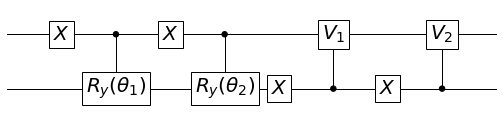

In [43]:
Ry1 = CreateOneQubitGate('Ry1', r'R_y(\theta_1)')
Ry2 = CreateOneQubitGate('Ry2', r'R_y(\theta_2)')
V1 = CreateOneQubitGate('V1', r'V_1')
V2 = CreateOneQubitGate('V2', r'V_2')

CircuitPlot(CGate(0,V2(1))*X(0)*CGate(0,V1(1))*X(0)*CGate(1,Ry2(0))*X(1)*CGate(1,Ry1(0))*X(1),2)

In [44]:
def two_element_povm(params, wires):
    #params 

    # Controlled-RY gate controlled by first qubit in |0> state
    qml.PauliX(wires=wires[0])
    qml.CRY(params[0], wires=[wires[0],wires[1]])
    qml.PauliX(wires=wires[0])
    
    # Controlled-RY gate controlled by first qubit in |1> state
    qml.CRY(params[1], wires=[wires[0],wires[1]])
    
    # Controlled-Rotation gate (arbitrary single-qubit unitary operator) controlled by 2nd qubit in |0> state
    qml.PauliX(wires=wires[1])
    qml.CRot(params[2], params[3], params[4], wires=[wires[1],wires[0]])
    qml.PauliX(wires=wires[1])

    # # Controlled-Rotation gate (arbitrary single-qubit unitary operator) controlled by 2nd qubit in |1> state
    qml.CRot(params[5], params[6], params[7], wires=[wires[1],wires[0]])

#### Test and Drawing `two_element_povm` module

In [45]:
@qml.qnode(dev)
def povm_circuit(params):
    two_element_povm(params, wires=[0, 1])
    return qml.expval(qml.Identity(0) @ qml.PauliZ(1))

# initial parameters
params = np.random.random([8])
povm_circuit(params)

print("Drawing a two-element POVM circuit : ")
print(povm_circuit.draw())

Drawing a two-element POVM circuit : 
 0: ──X──╭C───────────X──╭C─────────────╭Rot(0.0653, 0.428, 0.0965)─────╭Rot(0.127, 0.597, 0.226)──╭┤ ⟨I ⊗ Z⟩ 
 1: ─────╰RY(0.0796)─────╰RY(0.505)──X──╰C───────────────────────────X──╰C─────────────────────────╰┤ ⟨I ⊗ Z⟩ 



In [46]:
povm_circuit

<QNode: wires=3, device='default.qubit.autograd', interface='autograd', diff_method='backprop'>

---
## Three-element POVM Module.

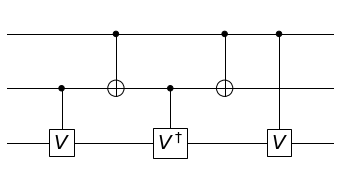

In [47]:
V = CreateOneQubitGate('V', r'V')
Vdg = CreateOneQubitGate('Vdg', r'V^\dagger')
CircuitPlot(CGate(2,V(0))*CNOT(2,1)*CGate((1),Vdg(0))*CNOT(2,1)*CGate((1),V(0)),3)

### Doubly controlled $\hat{R}_y(\theta)$

In [48]:
def CCRY(phi, wires):
    phi = phi/2
    qml.CRY(phi, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRY((-1)*phi, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRY(phi, wires=[wires[0], wires[2]])

In [49]:
@qml.qnode(dev)
def ccry_circuit(params):
    CCRY(params[0], wires=[0, 1, 2])
    return qml.expval(qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2))

# initial parameters
params = np.random.random([1])
ccry_circuit(params)

print("Drawing a CCRY circuit : ")
print(ccry_circuit.draw())

Drawing a CCRY circuit : 
 0: ───────────────╭C────────────────╭C──╭C───────────╭┤ ⟨I ⊗ Z ⊗ Z⟩ 
 1: ──╭C───────────╰X──╭C────────────╰X──│────────────├┤ ⟨I ⊗ Z ⊗ Z⟩ 
 2: ──╰RY(0.0535)──────╰RY(-0.0535)──────╰RY(0.0535)──╰┤ ⟨I ⊗ Z ⊗ Z⟩ 



CCRY 만들면서 params가 2배된다.

In [50]:
@qml.qnode(dev)
def ccry_circuit(params):
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    #qml.PauliX(wires=2)
    CCRY(params, wires=[0, 1, 2])
    return qml.state()
ccry_circuit(np.pi)

tensor([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j], requires_grad=True)

In [51]:
@qml.qnode(dev)
def cry_circuit(params):
    qml.PauliX(wires=0)
    qml.CRY(params, wires=[0, 1])
    return qml.state()
cry_circuit(np.pi)

tensor([0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j, 2.22044605e-16+0.j, 0.00000000e+00+0.j,
        1.00000000e+00+0.j, 0.00000000e+00+0.j], requires_grad=True)

### Doubly controlled Rotation $\hat{V}(\phi, \theta, \omega)$

$U(\phi,\theta,\omega)^\dagger = U(-\omega,-\theta,-\gamma)$

In [52]:
def CCRot(phi, theta, omega, wires):
    phi, theta, omega = phi/2, theta/2, omega/2
    qml.CRot(phi, theta, omega, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRot((-1)*omega, (-1)*theta, (-1)*phi, wires=[wires[1], wires[2]])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.CRot(phi, theta, omega, wires=[wires[0], wires[2]])

In [53]:
@qml.qnode(dev)
def ccrot_circuit(params):
    CCRot(params[0], params[1], params[2], wires=[0, 1, 2])
    return qml.expval(qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2))

# initial parameters
params = np.random.random([3])
ccrot_circuit(params)

print("Drawing a CCRY circuit : ")
print(ccrot_circuit.draw())

Drawing a CCRY circuit : 
 0: ────────────────────────────╭C───────────────────────────────╭C──╭C────────────────────────╭┤ ⟨I ⊗ Z ⊗ Z⟩ 
 1: ──╭C────────────────────────╰X──╭C───────────────────────────╰X──│─────────────────────────├┤ ⟨I ⊗ Z ⊗ Z⟩ 
 2: ──╰Rot(0.11, 0.175, 0.234)──────╰Rot(-0.234, -0.175, -0.11)──────╰Rot(0.11, 0.175, 0.234)──╰┤ ⟨I ⊗ Z ⊗ Z⟩ 



### Three-element POVM 

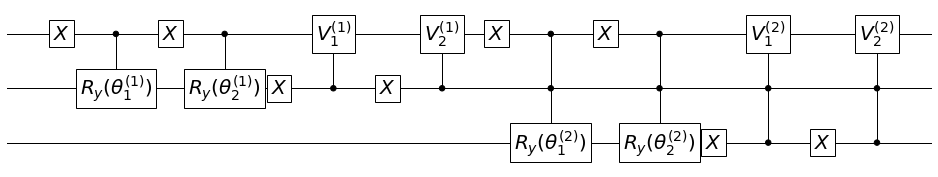

In [54]:
Ry11 = CreateOneQubitGate('Ry1', r'R_y(\theta^{(1)}_1)')
Ry12 = CreateOneQubitGate('Ry2', r'R_y(\theta^{(1)}_2)')
V11 = CreateOneQubitGate('V1', r'V^{(1)}_1')
V12 = CreateOneQubitGate('V2', r'V^{(1)}_2')
Ry21 = CreateOneQubitGate('Ry1', r'R_y(\theta^{(2)}_1)')
Ry22 = CreateOneQubitGate('Ry2', r'R_y(\theta^{(2)}_2)')
V21 = CreateOneQubitGate('V1', r'V^{(2)}_1')
V22 = CreateOneQubitGate('V2', r'V^{(2)}_2')



CircuitPlot(CGate((0,1),V22(2))*X(0)*CGate((0,1),V21(2))*X(0)*CGate((1,2),Ry22(0))*X(2)*CGate((1,2),Ry21(0))*X(2)*CGate(1,V12(2))*X(1)*CGate(1,V11(2))*X(1)*CGate(2,Ry12(1))*X(2)*CGate(2,Ry11(1))*X(2),3)

In [55]:
def three_element_povm(params, wires): 

    two_element_povm(params[:8], wires=[wires[0], wires[1]])
    
    qml.PauliX(wires=wires[0])
    CCRY(params[8], wires=[wires[0], wires[1], wires[2]])
    qml.PauliX(wires=wires[0])
    CCRY(params[9], wires=[wires[0], wires[1], wires[2]])

    qml.PauliX(wires=wires[2])
    CCRot(params[10], params[11], params[12], wires=[wires[2],wires[1],wires[0]])
    qml.PauliX(wires=wires[2])
    CCRot(params[13], params[14], params[15], wires=[wires[2],wires[1],wires[0]])
    

In [56]:
@qml.qnode(dev)
def povm_circuit(params):
    three_element_povm(params, wires=[0, 1, 2])
    return qml.expval(qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2))

# initial parameters
params = np.random.random([16])
povm_circuit(params)

print("Drawing a two-element POVM circuit : ")
print(povm_circuit.draw())

Drawing a two-element POVM circuit : 
 0: ──X──╭C──────────X──╭C────────────╭Rot(0.483, 0.505, 0.387)─────╭Rot(0.794, 0.58, 0.162)───X─────────╭C──────────────╭C──╭C──────────X──────────╭C───────────────╭C──╭C──────────╭Rot(0.25, 0.445, 0.171)──────╭Rot(-0.171, -0.445, -0.25)──────╭Rot(0.25, 0.445, 0.171)──╭Rot(0.284, 0.214, 0.218)──────╭Rot(-0.218, -0.214, -0.284)──────╭Rot(0.284, 0.214, 0.218)──╭┤ ⟨I ⊗ Z ⊗ Z⟩ 
 1: ─────╰RY(0.202)─────╰RY(0.64)──X──╰C─────────────────────────X──╰C────────────────────────╭C─────────╰X──╭C──────────╰X──│──────────╭C──────────╰X──╭C───────────╰X──│───────────╰C────────────────────────╭X──╰C───────────────────────────╭X──│─────────────────────────╰C─────────────────────────╭X──╰C────────────────────────────╭X──│──────────────────────────├┤ ⟨I ⊗ Z ⊗ Z⟩ 
 2: ──────────────────────────────────────────────────────────────────────────────────────────╰RY(0.35)──────╰RY(-0.35)──────╰RY(0.35)──╰RY(0.482)──────╰RY(-0.482)──────╰RY(0.482)───X───────────────────────

---
## Preparing arbitrary pure states in the quantum circuit

In [57]:
#@qml.qnode(dev)
def state_preparation(statevector, wire):
    theta = 2 * np.arccos(statevector[0])
    phi = np.angle(statevector[1]/np.sin(theta/2)) if not np.isclose(np.sin(theta/2), 0) else 0
    #print(theta, phi)

    qml.Rot(phi, theta, (-1)*phi, wires=wire)
    #return qml.state()

Examples <br>
$n=2$ <br>
$n=3$, $|\psi_0\rangle$

---
## Minimum Error Discrimination

Preparation: $\{q_i,\hat{\rho}_i\}^{N}_{i=1}$ $\longleftarrow$ $\hat{\rho} = \sum_i q_i\hat{\rho}_i$. <br>

POVMs: $\{E_k\}_{k=1}^{L}$ with $\sum_{k=1}^{L} E_k = I$.

For three-element POVMs $\{\hat{E}_0, \hat{E}_1, \hat{E}_2\}$ on three different state prepared as $\{(q_0,\hat{\rho}_0), (q_1,\hat{\rho}_1), (q_2,\hat{\rho}_2)\}$, 
$$
p_{error} = 1 - p_{guess} = 1-\max_{\vec{\theta}}\left(q_0\text{Tr}[\hat{E}_0\hat{\rho}_0] + q_1\text{Tr}[\hat{E}_1\hat{\rho}_1] + q_2\text{Tr}[\hat{E}_2\hat{\rho}_2]\right)
$$

---
## Probabilities

$$
p(k) = \langle \psi_k|\hat{K}^\dagger_k\hat{K}_k|\psi_k\rangle = \text{Tr}[\hat{E}_k\hat{\rho}_k]
$$

In [58]:
@qml.qnode(dev)
def circuit_povm_probs(init_state, params):

    # state preparation
    state_preparation(init_state, wire=0)

    # arbitrary rotation
    qml.Rot(params[0], params[1], params[2], wires=0)

    # three-element POVM
    three_element_povm(params[3:], wires=[0, 1, 2])

    #qml.CNOT(wires=[2,1])

    return qml.probs(wires=[1, 2])

In [59]:
state_vecs = [[1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)], [1/np.sqrt(2), 1/np.sqrt(2)], \
                [1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)]]

[circuit_povm_probs(state_vecs[i], params) for i in range(3)]

IndexError: index 13 is out of bounds for axis 0 with size 13

---
Optimal POVM for State Discrimination

In [60]:
def cost(x):
    psi0 = np.array([1/np.sqrt(2), np.exp(1j*2*np.pi/3)/np.sqrt(2)])
    psi1 = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
    psi2 = np.array([1/np.sqrt(2), np.exp(-1j*2*np.pi/3)/np.sqrt(2)])

    prob0 = circuit_povm_probs(psi0, x)[0]
    prob1 = circuit_povm_probs(psi1, x)[2]
    prob2 = circuit_povm_probs(psi2, x)[3]

    q0 = 1/3
    q1 = 1/3
    q2 = 1/3

    res = 1 - (q0 * prob0 + q1 * prob1 + q2 * prob2)
    return res


In [63]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 300

# set the initial parameter values
np.random.seed(1)
params = 4 * np.pi * np.random.random([19])

print("cost(init_params) =", cost(params))

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i+1) % 20 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

cost(init_params) = 0.6828178032150394
Cost after step    20:  0.6227101
Cost after step    40:  0.4983709
Cost after step    60:  0.3998543
Cost after step    80:  0.3752633
Cost after step   100:  0.3648510
Cost after step   120:  0.3536371
Cost after step   140:  0.3431094
Cost after step   160:  0.3369534
Cost after step   180:  0.3344866
Cost after step   200:  0.3336768
Cost after step   220:  0.3334341
Cost after step   240:  0.3333639
Cost after step   260:  0.3333433
Cost after step   280:  0.3333370
Cost after step   300:  0.3333348
Optimized rotation angles: [ 5.24004636 10.99556807 -0.1360504   3.14159267  1.23404439  1.160361
  2.34061485  4.34244417  4.84843945  7.84781143  5.26775363  6.28320605
  3.14158942 11.03474915  0.34416265  8.42534322  5.24400681  7.02070344
  1.7641543 ]


---

In [67]:
def unitaries_in_povm(params):
    U = qml.Rot(params[0], params[1], params[2], wires=2).matrix
    Ry00 = qml.RY(params[3], wires=2).matrix
    Ry01 = qml.RY(params[4], wires=2).matrix
    V00 = qml.Rot(params[5], params[6], params[7], wires=2).matrix
    V01 = qml.Rot(params[8], params[9], params[10], wires=2).matrix
    Ry10 = qml.RY(params[11], wires=2).matrix
    Ry11 = qml.RY(params[12], wires=2).matrix
    V10 = qml.Rot(params[13], params[14], params[15], wires=2).matrix
    V11 = qml.Rot(params[16], params[17], params[18], wires=2).matrix


    return U, Ry00, Ry01, V00, V01, Ry10, Ry11, V10, V11

U, Ry00, Ry01, V00, V01, Ry10, Ry11, V10, V11 = unitaries_in_povm(params)

$$
\hat{K}_0 = V^{(0)}_0D^{(0)}_0U \\
\hat{K}_1 = V^{(1)}_0D^{(1)}_0V^{(0)}_1D^{(0)}_1U \\
\hat{K}_2 = V^{(1)}_1D^{(1)}_1V^{(0)}_1D^{(0)}_1U 
$$

In [68]:
def kraus_op(params):
    U, _, _, V00, V01, _, _, V10, V11 = unitaries_in_povm(params)
    D00 = np.diag([np.cos(params[3]/2), np.cos(params[4]/2)])
    D01 = np.diag([np.sin(params[3]/2), np.sin(params[4]/2)])
    D10 = np.diag([np.cos(params[11]/2), np.cos(params[12]/2)])
    D11 = np.diag([np.sin(params[11]/2), np.sin(params[12]/2)])
    K0 = np.dot(np.dot(V00, D00), U)
    _mid = np.dot(np.dot(V01, D01), U)
    K1 = np.dot(np.dot(V10,D10),_mid)
    K2 = np.dot(np.dot(V11,D11),_mid)
    

    return K0, K1, K2

In [69]:
U, _, _, V00, V01, _, _, V10, V11 = unitaries_in_povm(params)
print(V00)
print(V01)
print(V10)
print(V11)

[[-0.36056483-0.14829206j  0.01864198+0.92068178j]
 [-0.01864198+0.92068178j -0.36056483+0.14829206j]]
[[-0.24035003-0.66732072j  0.68948578-0.14671153j]
 [-0.68948578-0.14671153j -0.24035003+0.66732072j]]
[[-0.93967973+0.29611005j -0.04502825-0.16520684j]
 [ 0.04502825-0.16520684j -0.93967973-0.29611005j]]
[[ 0.8721613 -0.3307636j  -0.06067404+0.35531504j]
 [ 0.06067404+0.35531504j  0.8721613 +0.3307636j ]]


In [70]:
K0, K1, K2 = kraus_op(params)

print("K0 =", K0)
print("K1 =", K1)
print("K2 =", K2)

K0 = [[-0.22298559+0.48200594j -0.30417029-0.43534954j]
 [-0.22439459-0.01423539j  0.12528352-0.18670561j]]
K1 = [[ 0.31392809+0.47576992j  0.31364111+0.47596107j]
 [-0.09906027+0.00117735j -0.09906215+0.0011188j ]]
K2 = [[-0.20731936+0.01561321j  0.11772692+0.17135391j]
 [-0.06342438+0.53424919j  0.49371225-0.21377194j]]


In [71]:
E0 = np.dot(K0.conj().T, K0) 
E1 = np.dot(K1.conj().T, K1)
E2 = np.dot(K2.conj().T, K2)
print("E0 =", E0)
print("E1 =", E1)
print("E2 =", E2)
print("E0 + E1 + E2 =", E0 + E1 + E2)

E0 = [[ 0.33260787+0.j         -0.16747059+0.28736775j]
 [-0.16747059-0.28736775j  0.33260373+0.j        ]]
E1 = [[0.33472219+0.j         0.33472315+0.00020235j]
 [0.33472315-0.00020235j 0.33472424+0.j        ]]
E2 = [[ 0.33266994+0.j        -0.16725256-0.2875701j]
 [-0.16725256+0.2875701j  0.33267202+0.j       ]]
E0 + E1 + E2 = [[ 1.00000000e+00+0.00000000e+00j -8.32667268e-17+1.66533454e-16j]
 [-8.32667268e-17-1.66533454e-16j  1.00000000e+00+0.00000000e+00j]]


(-0.16666666666666657+0.2886751345948129j)

---
In PRA,

Following JW Bae paper(Eq.(29) in p.16), <br>
I found that the guessing probability are the same!